# Introduction

This goal of this project is to analyze biodiversity data from the National Parks Service, particularly around various species observed in different national park locations. We will also use machine learning to predict a species conservation status and also to predict a geographical distribution based on enviormental variables

This project will scope, analyze, prepare, plot data, and seek to explain the findings from the analysis.

Here are a few questions that this project has sought to answer:

- What is the distribution of conservation status for species?
- Are certain types of species more likely to be endangered?
- Are the differences between species and their conservation status significant?
- Which animal is most prevalent and what is their distribution amongst parks?

**Data sources:**

Both `Observations.csv` and `Species_info.csv` was provided by [Codecademy.com](https://www.codecademy.com).


## Import Python Modules

First, import the primary modules that will be used in this project:

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import SVD, Dataset, Reader
from surprise.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Loading the Data

The `species_info.csv` contains information on the different species in the National Parks. The columns in the data set include:

- **category** - The category of taxonomy for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The species conservation status


In [2]:
species = pd.read_csv('species_info.csv',encoding='utf-8')
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


#### observations

The `Observations.csv` contains information from recorded sightings of different species throughout the national parks in the past 7 days. The columns included are:

- **scientific_name** - The scientific name of each species
- **park_name** - The name of the national park
- **observations** - The number of observations in the past 7 days

In [3]:
observations = pd.read_csv('observations.csv', encoding='utf-8')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


#### Data Characteristics


In [4]:
print(f"species shape: {species.shape}")
print(f"observations shape: {observations.shape}")

species shape: (5824, 4)
observations shape: (23296, 3)


## Explore the Data

#### species

In [5]:
print(f"number of species: {species.scientific_name.nunique()}")

number of species: 5541


In [6]:
print(f"number of categories: {species.category.nunique()}")
print(f"categories: {species.category.unique()}")

number of categories: 7
categories: ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


In [7]:
species.groupby("category").size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

In [8]:
print(f"number of conservation statuses: {species.conservation_status.nunique()}")
print(f"unique conservation statuses: {species.conservation_status.unique()}")

number of conservation statuses: 4
unique conservation statuses: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [9]:
print(f"na values:{species.conservation_status.isna().sum()}")

print(species.groupby("conservation_status").size())

na values:5633
conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64


In [10]:
species['conservation_status'] = species['conservation_status'].fillna('No Intervention')

#### observations

In [11]:
print(f"number of parks: {observations.park_name.nunique()}")
print(f"unique parks: {observations.park_name.unique()}")

number of parks: 4
unique parks: ['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


In [12]:
print(f"number of observations: {observations.observations.sum()}")

number of observations: 3314739


## Analysis

In [13]:
species.fillna('No Intervention', inplace=True)
species.groupby("conservation_status").size()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

In [14]:
conservationCategory = species[species.conservation_status != "No Intervention"]\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

conservationCategory

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


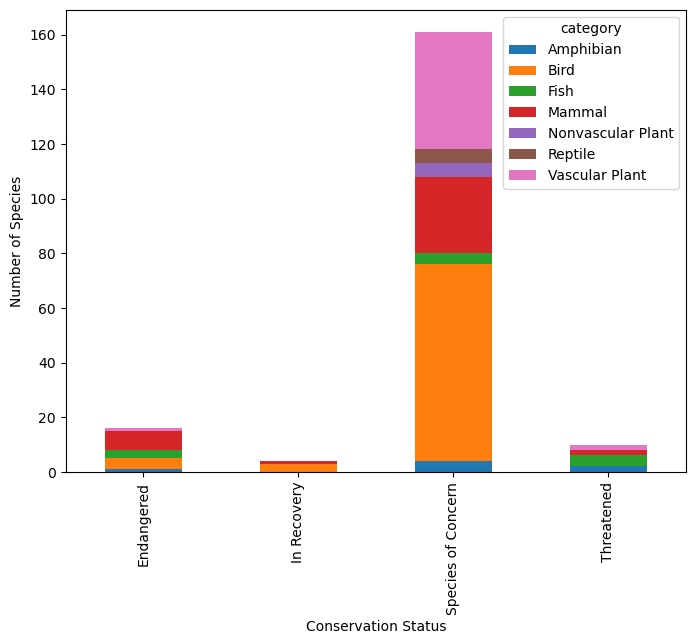

In [15]:
ax = conservationCategory.plot(kind = 'bar', figsize=(8,6), 
                               stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");

Adding a new column called `is_protected` and it will include any species that had a value other than `No Intervention`. 

In [16]:
species['is_protected'] = species.conservation_status != 'No Intervention'

With the new column `is_protected`, we can group by `category` and `is_protected` to show the break down of each species type and protection status. 


In [17]:
category_counts = species.groupby(['category', 'is_protected'])\
                        .scientific_name.nunique()\
                        .reset_index()\
                        .pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']

category_counts

,category,not_protected,protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


In [18]:
category_counts['percent_protected'] = category_counts.protected / \
                                      (category_counts.protected + category_counts.not_protected) * 100

category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


#### Statistical Significance

We will use chi-squared tests to see if different species have statistically significant differences in conservation status rates. In order to run a chi squared test, a contingency table will need to be created. 

The first test will be called `contingency1` and will need to be filled with the correct numbers for mammals and birds.


In [19]:
from scipy.stats import chi2_contingency

contingency1 = [[30, 146],
              [75, 413]]
chi2_contingency(contingency1)

Chi2ContingencyResult(statistic=0.1617014831654557, pvalue=0.6875948096661336, dof=1, expected_freq=array([[ 27.8313253, 148.1686747],
       [ 77.1686747, 410.8313253]]))

The next pair, is going to test the difference between `Reptile` and `Mammal`.


Mammals are shown to have a statistically significant higher rate of needed protection compared with Reptiles. 

In [20]:
contingency2 = [[30, 146],
               [5, 73]]
chi2_contingency(contingency2)

Chi2ContingencyResult(statistic=4.289183096203645, pvalue=0.03835559022969898, dof=1, expected_freq=array([[ 24.2519685, 151.7480315],
       [ 10.7480315,  67.2519685]]))

#### Species in Parks

Looking at `species`, we will need to get an idea of the most prevalent animals in the dataset. The data will be need to be split up into individual names. 

In [21]:
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species[species.category == "Mammal"]\
    .common_names\
    .apply(remove_punctuations)\
    .str.split().tolist()

common_Names[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

The next step is to clean up duplicate words in each row since they should no be counted more than once per species.

In [22]:
cleanRows = []

for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
cleanRows[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

Next the words need to be collapsed into one list for easier use.

In [23]:
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
res[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

Now the data is ready to be able to count the number of occurrences of each word.

In [24]:
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count']).sort_values("Count", ascending = False).head(10)

,Word,Count
31,Bat,23
148,Shrew,18
64,Myotis,17
181,Mouse,16
198,Chipmunk,13
80,American,12
16,Squirrel,12
118,Eastern,11
125,Vole,11
69,Western,10


In the data, there are several different scientific names for different types of bats.  The next task is to figure out which rows of `species` are referring to bats. A new column made up of boolean values will be created to check if `is_bat` is `True`.

In [25]:
species['is_bat'] = species.common_names.str.contains(r"\bBat\b", regex = True)
species.head(10)

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False
5,Mammal,Odocoileus virginianus,White-Tailed Deer,No Intervention,False,False
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",No Intervention,False,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True,False
8,Mammal,Canis lupus,Gray Wolf,Endangered,True,False
9,Mammal,Canis rufus,Red Wolf,Endangered,True,False


Here is a subset of the data where `is_bat` is true, returning see the rows that matched. There seems to be a lot of species of bats and a mix of protected vs. non-protected species. 

In [26]:
species[species.is_bat]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Intervention,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Intervention,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,No Intervention,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,No Intervention,False,True


Next the results of the bat species will be merged with `observations` to create a `DataFrame` with observations of bats across the four national parks.  

In [27]:
bat_observations = observations.merge(species[species.is_bat])
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Intervention,False,True
...,...,...,...,...,...,...,...,...
139,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
140,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
141,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


Let's see how many total bat observations across all species were made at each national park.  

In [28]:
bat_observations.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3433
1,Great Smoky Mountains National Park,2411
2,Yellowstone National Park,8362
3,Yosemite National Park,4786


Now let's see each park broken down by protected bats vs. non-protected bat sightings. It seems that every park except for the Great Smoky Mountains National Park has more sightings of protected bats than not. This could be considered a great sign for bats.

In [29]:
obs_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
obs_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1596
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1299
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4044
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2345
7,Yosemite National Park,True,2441


Below is a plot from the output of the last data manipulation. From this chart one can see that Yellowstone and Bryce National Parks seem to be doing a great job with their bat populations since there are more sightings of protected bats compared to non-protected species. The Great Smoky Mountains National Park might need to beef up there efforts in conservation as they have seen more non-protected species.

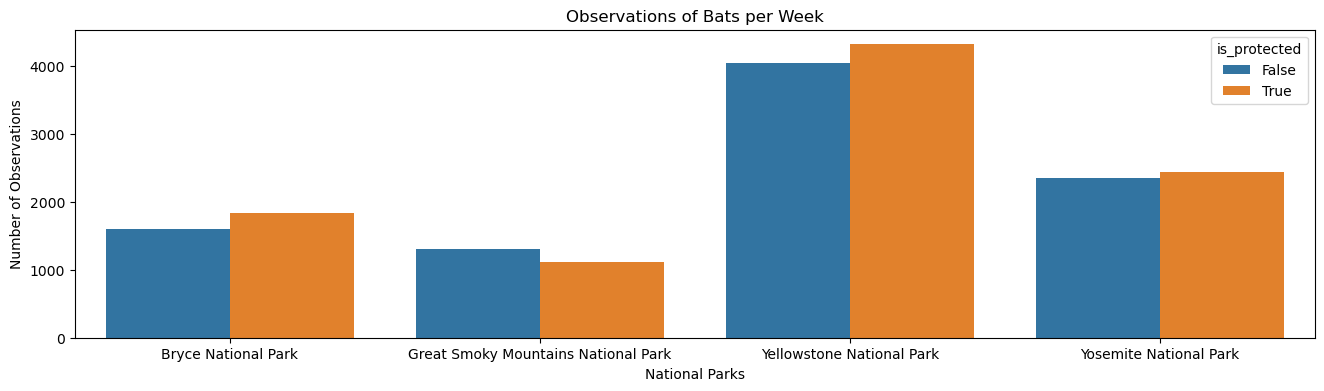

In [30]:
plt.figure(figsize=(16, 4))
sns.barplot(x=obs_by_park.park_name, y= obs_by_park.observations, hue=obs_by_park.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats per Week')
plt.show()

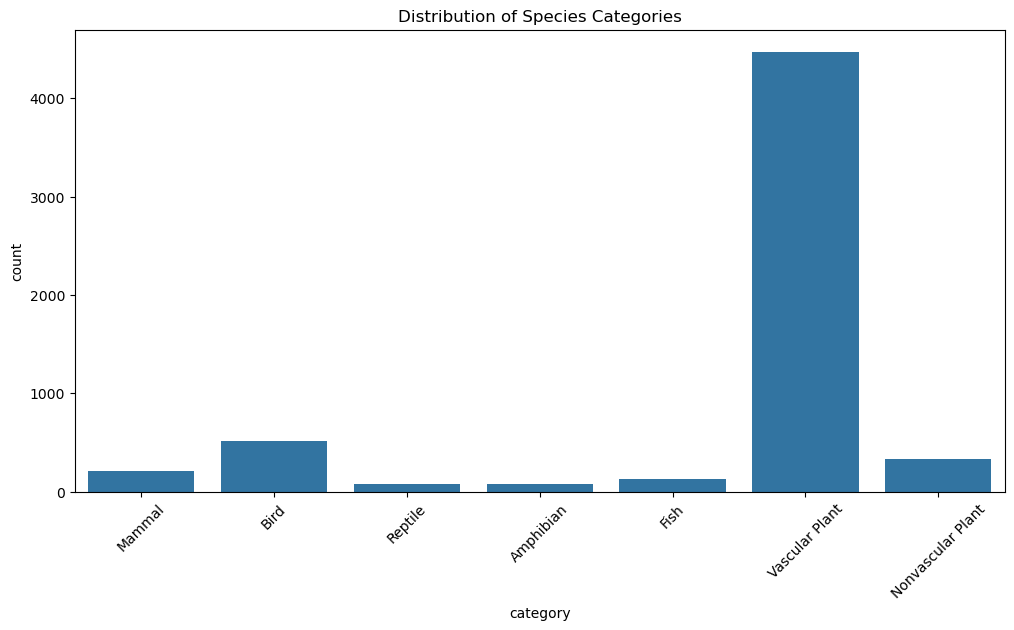

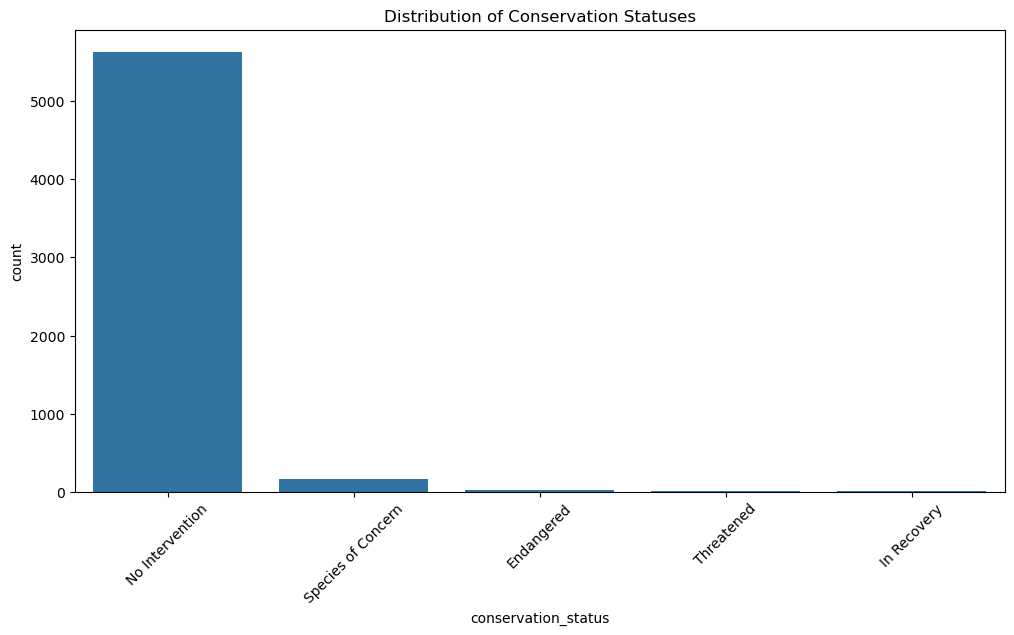

In [31]:
# Plot the distribution of categories
plt.figure(figsize=(12, 6))
sns.countplot(data=species, x='category')
plt.title('Distribution of Species Categories')
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of conservation statuses
plt.figure(figsize=(12, 6))
sns.countplot(data=species, x='conservation_status')
plt.title('Distribution of Conservation Statuses')
plt.xticks(rotation=45)
plt.show()


In [32]:
# Merge datasets
merged_data = pd.merge(observations, species, on='scientific_name')

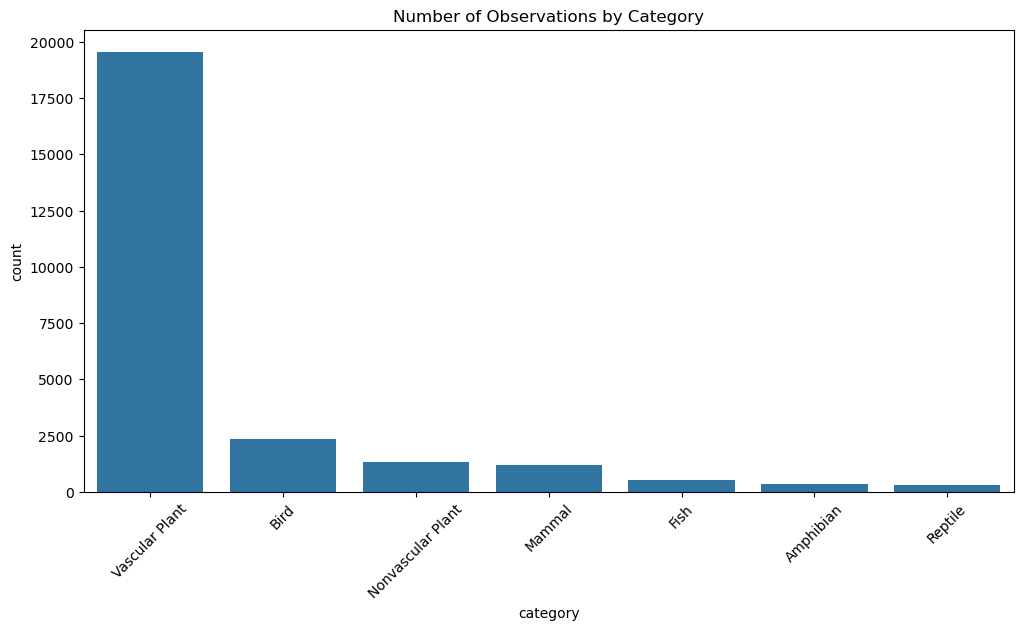

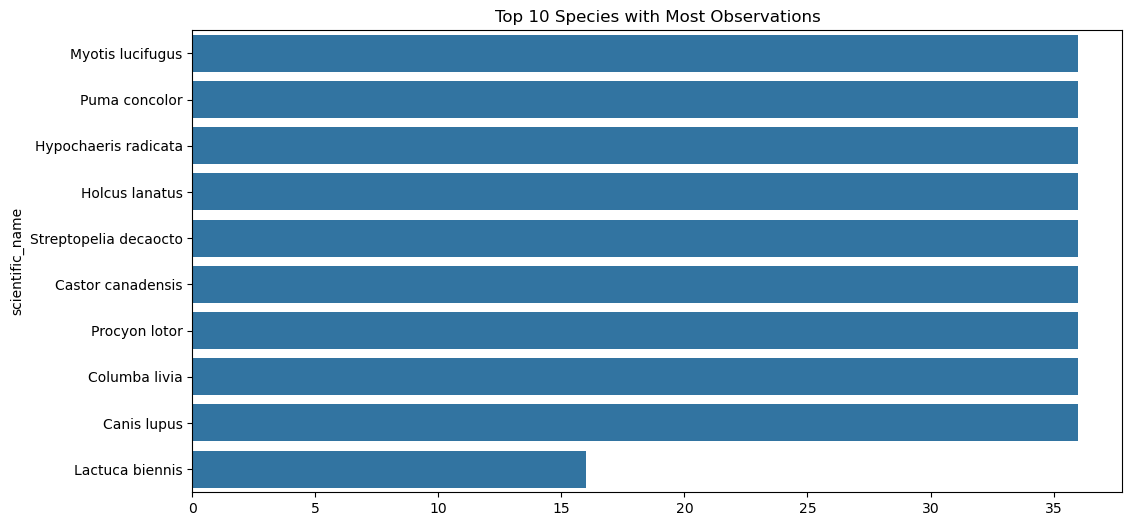

In [33]:
# Plot the number of observations by category
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_data, x='category', order=merged_data['category'].value_counts().index)
plt.title('Number of Observations by Category')
plt.xticks(rotation=45)
plt.show()

# Top 10 species with the most observations
top_species = merged_data['scientific_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_species.values, y=top_species.index)
plt.title('Top 10 Species with Most Observations')
plt.show()


### Machine Learning

We will use leaverage machine learning to predict conservation status via random forest classifier

In [34]:
label_encoder = LabelEncoder()
species['category_encoded'] = label_encoder.fit_transform(species['category'])
species['conservation_status_encoded'] = label_encoder.fit_transform(species['conservation_status'])

In [35]:
X = species[['category_encoded']]
y = species['conservation_status_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [37]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.967381974248927
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.97      1.00      0.98      1127
           3       0.00      0.00      0.00        36

    accuracy                           0.97      1165
   macro avg       0.24      0.25      0.25      1165
weighted avg       0.94      0.97      0.95      1165



#### Lets see if we can get better results using SMOTE

In [38]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [39]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)

In [40]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8188841201716738
Classification Report:
              precision    recall  f1-score   support

           0       0.02      1.00      0.04         1
           1       0.01      1.00      0.02         1
           2       0.99      0.84      0.91      1127
           3       0.08      0.03      0.04        36
           4       0.00      0.00      0.00         0

    accuracy                           0.82      1165
   macro avg       0.22      0.57      0.20      1165
weighted avg       0.96      0.82      0.88      1165



#### Applying our Machine Learning findings to our dataset

In [41]:
species['predicted_conservation_status'] = model.predict(species[['category_encoded']])

# Decode the predicted conservation status
species['predicted_conservation_status'] = label_encoder.inverse_transform(species['predicted_conservation_status'])

# Identify species predicted to need conservation status
species_needing_conservation = species[(species['conservation_status'] == 'No Intervention') &  (species['predicted_conservation_status'] != 'No Intervention')]

# Display species needing conservation status
species_needing_conservation[['scientific_name', 'predicted_conservation_status']]

,scientific_name,predicted_conservation_status
0,Clethrionomys gapperi gapperi,Endangered
1,Bos bison,Endangered
2,Bos taurus,Endangered
3,Ovis aries,Endangered
4,Cervus elaphus,Endangered
...,...,...
4609,Catostomus occidentalis,Threatened
4610,Mylopharodon conocephalus,Threatened
4611,Ptychocheilus grandis,Threatened
4613,Oncorhynchus mykiss aguabonita,Threatened


## Conclusions

The project was able to make several data visualizations and inferences about the various species in four of the National Parks that comprised this data set.

Some of the highlights from our analysis:

- The vast majority of species were not part of conservation.(5,633 vs 191)

- Mammals and Birds had the highest percentage of being in protection.

- While mammals and Birds did not have significant difference in conservation percentage, mammals and reptiles exhibited a statistically significant difference.

- the study found that bats occurred the most number of times and they were most likely to be found in Yellowstone National Park.
